하나의 idx에 대하여 1:4까지의 feature(가격정보)를 투입하여 120분 뒤의 가격을 예측하는 LSTM 모델

In [1]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

%matplotlib inline

In [2]:

# 3차원 array로 변경
def df2d_to_array3d(df_2d):

    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

#x 데이터셋 생성 함수
def create_dataset(signal_data, look_back):
    dataX, dataY = [], []
    for i in range(int((len(signal_data)-look_back))):
        dataX.append(signal_data[i:(i+look_back)])

    return np.array(dataX)

#loss 기록 함수
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))


#maxmin scaler
def maxminscaler(arrayy,featurelength):
  new_array = np.zeros((arrayy.shape[0], arrayy.shape[1], featurelength))
  for i in range(arrayy.shape[0]):
    for j in range(arrayy.shape[1]):
      for k in range(featurelength):
        new_array[i,j,k] = (arrayy[i,j,k] - np.min(arrayy[i,:,k]))/(np.max(arrayy[i,:,k]) - np.min(arrayy[i,:,k]))

  return new_array

In [3]:
#데이터 불러오기
train_x_df = pd.read_csv('/content/drive/MyDrive/capstone2021/train_x_df.csv')
train_y_df = pd.read_csv('/content/drive/MyDrive/capstone2021/train_y_df.csv')
test_x_df = pd.read_csv('/content/drive/MyDrive/capstone2021/test_x_df.csv')
sample_submission=pd.read_csv('/content/drive/MyDrive/capstone2021/sample_submission.csv')
train_x_df = train_x_df.astype('float')
train_y_df = train_y_df.astype('float')
test_x_df = test_x_df.astype('float')
sample_submission=sample_submission.astype('float')


In [4]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [5]:
key = maxminscaler(train_x_array, 6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


In [6]:
#코인별 인덱스 뽑기
def coinindex(sampleidlength, coinnumber):
    index = []
    for x in range(sampleidlength):
        if train_x_array[x, 0, 0] == coinnumber:
            index.append(x)
    return index


for i in range(10):
    globals()['coin{}'.format(i)] = coinindex(train_x_array.shape[0], i)

In [7]:
#idx 선택 및 feature 고르기
idx = coin9[-1]
signaldata=train_x_array[idx,:,[1,2,3,4]]



signaldata = signaldata.reshape(1380,signaldata.shape[0])


In [8]:
#하나의 인덱스에 대하여 학습구간 설정
look_back=120
train_len = 1000
val_len = 1260

train= signaldata[:train_len,:]
val = signaldata[train_len-look_back:val_len,:]
test= signaldata[val_len-look_back:,:]



In [9]:
# 데이터셋 생성
x_train = create_dataset(train, look_back)
x_val = create_dataset(val, look_back)
x_test = create_dataset(test, look_back)
y_train = signaldata[240:1240-look_back,0]
y_val = signaldata[1240-look_back:1380,0]

In [ ]:
# 데이터셋 생성
x_train = create_dataset(train, look_back)
x_val = create_dataset(val, look_back)
x_test = create_dataset(test, look_back)
y_train = signaldata[120:1120-look_back,0]
y_val = signaldata[1120-look_back:1380-look_back,0]


(880, 120, 4)
(260, 120, 4)
(120, 120, 4)
(880,)
(260,)


In [10]:
#모델
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1],x_train.shape[2] )))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [11]:
# 3. 모델1 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')


In [12]:
# 4. 모델 1학습시키기
custom_hist = CustomHistory()
custom_hist.init()

In [13]:
for i in range(1):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(x_val, y_val))
    print("epoch" +str(i+1))
    model.reset_states()

880/880 [==============================] - 71s 60ms/step - loss: 0.0104 - val_loss: 3.9881e-05
epoch1


In [14]:
#test set 결과 추출
predictions = model.predict(x_test)

Model : LSTM
input data : t-240 ~ t-120의 open, high, low, close 
output data : t 시점의 open


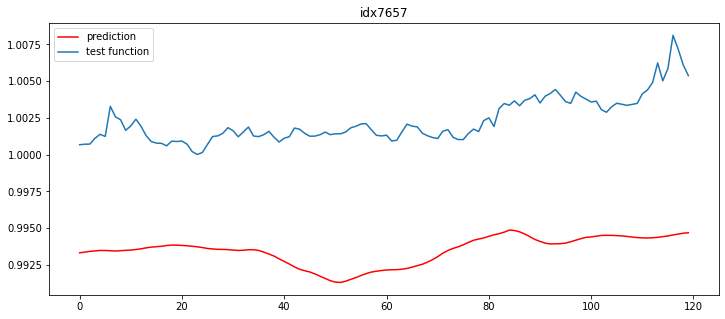

MSE
120/120 [==============================] - 1s 12ms/step - loss: 7.9041e-05
7.904133963165805e-05


In [15]:
#plotting
print("Model : LSTM")
print("input data : t-240 ~ t-120의 open, high, low, close ")
print("output data : t 시점의 open")
plt.figure(figsize=(12,5))
plt.title('idx'+str(idx))
plt.plot((predictions),'r',label="prediction")
plt.plot(train_y_array[idx,:,1],label="test function")
plt.legend()
plt.show()
print("MSE")
print(model.evaluate(x_test,train_y_array[idx,:,1], batch_size=1))


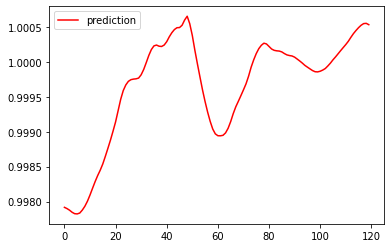

48

In [ ]:
plt.clf()
plt.plot((predictions),'r',label="prediction")
plt.legend()
plt.show()
np.argmax(predictions)